<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/Shakespeare_LM_v6_v5%2BOpenWebText_Dataset%2BTokenizer_BPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np


In [46]:
USE_GPU = True

BLOCK_SIZE = 96 # Context length: how many chars do we take to predict the next one?

# number of workers in .map() call
# good number to use is ~order number of cpu cores // 2
NUM_PROC = 24

# Setup GPU

In [47]:
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  assert device.type != 'cpu', "GPU is not available"
else:
  device = 'cpu'

print(device)

cuda:0


In [48]:
g_cpu = torch.Generator(device='cpu').manual_seed(2147483647) # for reproducibility
g_device = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# Util Functions

# Tokenizer

In [55]:
!pip install tiktoken

import tiktoken

enc = tiktoken.get_encoding("gpt2")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.2 MB/s eta 0:00:00


In [78]:
test = enc.encode("how are you little yo I don't know \n man")

back = enc.decode(test + [enc.eot_token])


test, back

([4919, 389, 345, 1310, 27406, 314, 836, 470, 760, 220, 198, 582],
 "how are you little yo I don't know \n man<|endoftext|>")

In [88]:
vocab_size = enc.n_vocab
print(f'{vocab_size=}')

vocab_size=50257


# Load data

## Open Web Text DS

- See nanoGPT impl: https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

In [31]:
# Download data - openwebtext

!pip install datasets # Since we are running in colab docker image, install it here.

from datasets import load_dataset # huggingface datasets

In [32]:
dataset = load_dataset("openwebtext", num_proc=NUM_PROC)

In [33]:
# By default it only contains the 'train' split, so create a test split

split_dataset = dataset['train'].train_test_split(test_size=0.1, seed=2357, shuffle=True)
split_dataset['dev'] = split_dataset.pop('test')  # rename the test split to val

In [34]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 7212392
    })
    dev: Dataset({
        features: ['text'],
        num_rows: 801377
    })
})

In [62]:
i = 0

for it in split_dataset.get('train'):
  print(it)
  if i > 3:
    break
  i += 1

{'text': 'Expecting DOT Street Safety Projects to Deliver More Than the Minimum\n\nA DOT plan to add painted bike lanes and sharrows to Spring Street [PDF] doesn’t go far enough to prioritize walking and biking, says Community Board 2 transportation vice-chair Maury Schott.\n\nLast Thursday, DOT presented the proposal to the CB 2 transportation committee. Two-thirds of the audience supported the plan, meeting attendees said, and neighborhood NIMBY ringleader Sean Sweeney was a no-show. In the end, the plan received a unanimous 10-0 vote.\n\nThe lack of opposition, however, may be a sign of DOT timidity more than anything else. “The proposal by DOT was, to say the least, minimally intrusive,” Schott told Streetsblog. “It was as much as you could hope to do without making the commitment to remove parking on at least one side of the street.”\n\nAlthough DOT has been on a roll this year with proposals for road diets and protected bike lanes, the agency’s designs usually don’t subtract much

In [68]:
def process(example):
  # ignores any special tokens
  ids = enc.encode_ordinary(example['text'])

  # Add the end of text token, e.g. 50256 for gpt2 bpe
  ids.append(enc.eot_token)
  out = {'ids': ids, 'len': len(ids)}
  return out

In [69]:
i = 0

for it in split_dataset.get('train'):
  print(process(it))
  if i > 3:
    break
  i += 1

{'ids': [3109, 35570, 42743, 3530, 11233, 29898, 284, 43371, 3125, 17924, 262, 26265, 198, 198, 32, 42743, 1410, 284, 751, 13055, 7161, 15296, 290, 427, 6018, 82, 284, 8225, 3530, 685, 20456, 60, 1595, 447, 247, 83, 467, 1290, 1576, 284, 32980, 6155, 290, 38088, 11, 1139, 8108, 5926, 362, 9358, 7927, 12, 16337, 6669, 1601, 3059, 1252, 13, 198, 198, 5956, 3635, 11, 42743, 5545, 262, 6961, 284, 262, 10078, 362, 9358, 5583, 13, 4930, 12, 17936, 286, 262, 5386, 4855, 262, 1410, 11, 3249, 21736, 531, 11, 290, 6232, 399, 3955, 17513, 5858, 27940, 11465, 47005, 373, 257, 645, 12, 12860, 13, 554, 262, 886, 11, 262, 1410, 2722, 257, 28085, 838, 12, 15, 3015, 13, 198, 198, 464, 3092, 286, 5471, 11, 2158, 11, 743, 307, 257, 1051, 286, 42743, 4628, 17995, 517, 621, 1997, 2073, 13, 564, 250, 464, 6961, 416, 42743, 373, 11, 284, 910, 262, 1551, 11, 10356, 453, 39930, 11, 447, 251, 3059, 1252, 1297, 27262, 14036, 13, 564, 250, 1026, 373, 355, 881, 355, 345, 714, 2911, 284, 466, 1231, 1642, 262, 7901,

In [70]:
tokenized = split_dataset.map(
    process,
    remove_columns=['text'],
    desc='tokenizing the splits',
    num_proc=NUM_PROC,
)

tokenizing the splits (num_proc=24):   0%|          | 0/7212392 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=24):   0%|          | 0/801377 [00:00<?, ? examples/s]

In [ ]:
data_dir = os.path.join('data', dataset)

In [73]:
import os
from tqdm import tqdm
import numpy as np

# concatenate all the ids in each dataset into one large file we can use for training
for split, dset in tokenized.items():
    arr_len = np.sum(dset['len'], dtype=np.uint64)
    filename = os.path.join(os.path.dirname('ds'), f'{split}.bin')
    dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
    arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
    total_batches = 1024

    idx = 0
    for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
        # Batch together samples for faster write
        batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
        arr_batch = np.concatenate(batch['ids'])
        # Write into mmap
        arr[idx : idx + len(arr_batch)] = arr_batch
        idx += len(arr_batch)
    arr.flush()

writing dev.bin: 100%|██████████| 1024/1024 [00:28<00:00, 35.57it/s]


# Create DS

In [257]:
train_data = np.memmap(os.path.join(os.path.dirname('ds'), 'train.bin'), dtype=np.uint16, mode='r')
dev_data = np.memmap(os.path.join(os.path.dirname('ds'), 'dev.bin'), dtype=np.uint16, mode='r')
print(f'{train_data.shape=}, {dev_data.shape=}')

train_data.shape=(8136098388,), dev_data.shape=(903918707,)


In [258]:
train_data

memmap([ 3109, 35570, 42743, ..., 13815,    13, 50256], dtype=uint16)

In [259]:
# str ---> list of integer
# encode = tokenizer.encode
encode = lambda str: enc.encode(str)

# list of integer ---> str
decode = enc.decode

_test_str = "adb dfd \nplace"

# TODO: this fails  because the tokenizer's encoding result doesn't include "\n"
# assert _test_str == decode(encode(_test_str).ids)

In [260]:
def get_batch(data, batch_size: int, block_size: int):
  """ Sample a batch using Causal style. """
  x_list = []
  y_list = []
  ix = torch.randint(0, len(data)-block_size, (batch_size,), generator=g_cpu)
  # X = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix]).to(device)
  X = torch.stack([torch.from_numpy(np.array(data[i:i+block_size], dtype=np.int64)) for i in ix]).to(device)
  # X = torch.stack([torch.tensor(data[i:i+block_size].astype(np.int64)) for i in ix]).to(device)
  # Y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix]).to(device)
  Y = torch.stack([torch.from_numpy(np.array(data[i+1:i+1+block_size], dtype=np.int64)) for i in ix]).to(device)
  return X, Y

In [261]:
X, Y = get_batch(train_data, 16, BLOCK_SIZE)

for b in range(3):
  it = 0
  for t in range(X.shape[1]):
    print(f'{decode(X[b, :t+1].tolist())} ---> {decode([Y[b, t].item()])}')
    it += 1
    if it > 7:
      break

 me ---> ,
 me, --->  or
 me, or --->  my
 me, or my --->  neighbors
 me, or my neighbors ---> ,
 me, or my neighbors, --->  whether
 me, or my neighbors, whether --->  they
 me, or my neighbors, whether they --->  are
 spared --->  the
 spared the --->  pe
 spared the pe ---> ll
 spared the pell ---> -
 spared the pell- ---> m
 spared the pell-m ---> ell
 spared the pell-mell --->  development
 spared the pell-mell development --->  that
14 ---> ]
14] --->  This
14] This --->  is
14] This is --->  especially
14] This is especially --->  prevalent
14] This is especially prevalent --->  amongst
14] This is especially prevalent amongst --->  teenagers
14] This is especially prevalent amongst teenagers ---> .


In [262]:
X, Y = get_batch(dev_data, 16, BLOCK_SIZE)

for b in range(3):
  it = 0
  for t in range(X.shape[1]):
    print(f'{decode(X[b, :t+1].tolist())} ---> {decode([Y[b, t].item()])}')
    it += 1
    if it > 7:
      break

– ---> cl
–cl ---> arity
–clarity --->  that
–clarity that --->  is
–clarity that is --->  particularly
–clarity that is particularly --->  necessary
–clarity that is particularly necessary --->  in
–clarity that is particularly necessary in --->  light
 Europe ---> .
 Europe. ---> The
 Europe.The --->  Norwegian
 Europe.The Norwegian --->  broadcaster
 Europe.The Norwegian broadcaster --->  NR
 Europe.The Norwegian broadcaster NR ---> K
 Europe.The Norwegian broadcaster NRK --->  has
 Europe.The Norwegian broadcaster NRK has --->  interviewed
, --->  the
, the --->  old
, the old --->  Marxist
, the old Marxist --->  theory
, the old Marxist theory ---> .
, the old Marxist theory. --->  They
, the old Marxist theory. They --->  may
, the old Marxist theory. They may --->  be


# Modeling

In [263]:
n_embd = 768 # the dimensionality of the character embedding vectors
d_head = 2 * n_embd # the dim of the transformer's head
N_HIDDEN = n_embd * 4 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

## Model class

In [264]:
class LayerNorm(torch.nn.Module):
  """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

  def __init__(self, ndim: int, bias: bool):
    super().__init__()
    self.weight = torch.nn.Parameter(torch.ones(ndim))
    self.bias = torch.nn.Parameter(torch.zeros(ndim)) if bias else None

  def forward(self, x):
    return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

In [265]:
class AttentionBlock(torch.nn.Module):

  def __init__(self, vocab_size, d_in, d_hidden, d_head):
    """
    Args:
      vocab_size: volabulary size
      d_in: dim of input. If this is the immediate next layer of the token
        embedding layer, this is the dim of the embedding for a token.
      d_hidden: dim of hidden FFN layers
      d_head: dim of the transformer head
    """
    super().__init__()

    self.d_head = d_head
    self.key1 = torch.nn.Linear(d_in, d_head, bias=False)
    self.query1 = torch.nn.Linear(d_in, d_head, bias=False)
    self.value1 = torch.nn.Linear(d_in, d_head, bias=False)

    self.linear1 = torch.nn.Linear(d_head, d_hidden, bias=True)
    self.tanh1 = torch.nn.Tanh()
    # Project d_hidden back to d_head as output
    self.proj = torch.nn.Linear(d_hidden, d_head, bias=True)

    self.ln1 = LayerNorm(d_in, bias=True)
    self.ln2 = LayerNorm(d_head, bias=True)

  def forward(self, x):
    """
    Args:
      x: (B, T, C). The input to the model.
    Returns:
      loss: int
      logits: (B, T, C)
    """

    T = x.shape[-2]
    tril = torch.tril(torch.ones(T, T)).to(device)

    x = self.ln1(x)

    k = self.key1(x)  # (B, T, d_head)
    q = self.query1(x) # (B, T, d_head)
    wei = k @ q.transpose(-2, -1) # (B, T, d_head) @ (B, d_head, T) = (B, T, T)
    wei = wei.masked_fill(tril==0, -float('inf')) # (B, T, T)
    wei = wei * self.d_head**-0.5
    wei = F.softmax(wei, dim=-1) # (B, T, T)

    v = self.value1(x) # (B, T, d_head)
    # This makes the y[:,t,:], to have the information of the embedding (v)
    # v[:, u (u<=t), :], but not have the infomration of v[:, w (w>t), :]
    #
    # 1. Spread v's information at all t to y[:, any t, :]
    #
    # Because v is on rhs of @, its information at different T are spread out to
    # the different T in y
    #
    # Think about (T, T) @ (T, d_head) = (T, d_head)
    #
    # a11, a12     b1   a11*b1+a12*b2
    # a21, a22  @  b2 = a21*b1+a22*b2
    #
    # In the result, at T=1, it has b1 and b2, which are the rhs of @'s info at
    # different T
    #
    # 2. Limit y[:, t, :] to not access v[:, w (w>t), :].
    #
    # This is done by `tril`
    y = wei @ v # (B, T, d_head)

    y = self.ln2(y)

    # It doesn't need tril here, because the lhs and rhs doesn't exchange
    # information at different T.
    #
    # Let's say:
    # - input is y (B, T, d_head)
    # - Linear(d_in, d_out) is a matrix l(d_in, d_out), here dim is l(d_head, d_hidden)
    # - result is z (B, T, d_hidden)
    #
    # linear(y) = y @ l = z
    #
    # To simplify, ignore B, T=3, d_head=2, d_hidden=1
    #
    #         y11 y12         y11*l1+y12*l2
    # y @ l = y21 y22 @ l1  = y21*l1+y22*l2
    #         y31 y32   l2    y31*l1+y32*l2
    #
    # We can see z[:, T, :] only contains y[:, T, :]'s info
    #
    # To summarize this and the previous section
    #
    # Z = X @ Y
    #
    # Z[T, :] only contains X[T, :]'s info, doesn't contain X[S != T, :]'s infor
    # Z[T, :] contains Y[at any index, :]'s info
    y = self.linear1(y) # (B, T, d_hidden)
    y = self.tanh1(y) # (B, T, d_hidden)
    y = self.proj(y) # (B, T, d_head)

    return y

  def generate(self, idx, max_new_tokens: int):
    """Generate new tokens given idx as context.

    Args:
      idx: (B, T)
      max_new_tokens: number of new tokens to generate

    Returns:
      (B,T+max_new_tokens)
    """
    for _ in range(max_new_tokens):
      logits, loss = self(idx, targets=None)  # logits: (B, T, vocab_size), loss: None
      logits = logits[:, -1, :] # (B, vocab_size)
      prob = F.softmax(logits, dim=1) # (B, vocab_size)
      idx_next = torch.multinomial(prob, num_samples=1, replacement=False)  # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [266]:
class Net(torch.nn.Module):

  def __init__(self, vocab_size, d_embd, d_hidden, d_head):
    """
    Args:
      vocab_size: volabulary size
      d_embd: dim of embedding for the token
      d_hidden: dim of hidden FFN layers
      d_head: dim of the transformer head
    """
    super().__init__()

    self.d_head = d_head

    self.embd = torch.nn.Embedding(
        num_embeddings=vocab_size,
        embedding_dim=d_embd
    )
    self.attn1 = AttentionBlock(vocab_size, d_embd, d_hidden, d_head)
    self.attn2 = AttentionBlock(vocab_size, d_head, d_hidden, d_head)
    self.linear_logit = torch.nn.Linear(d_head, vocab_size, bias=True)


  def forward(self, x, targets=None):
    """
    Args:
      x: (B, T). The input to the model.
      targets: (B, T). When it is not None, the func calculates and return the
        loss in additional to other returned item(s)
    Returns:
      loss: int
      logits: (B, T, C)
    """

    T = x.shape[-1]
    tril = torch.tril(torch.ones(T, T)).to(device)

    xemb = self.embd(x) # (B, T, C)

    y = self.attn1(xemb)
    y = self.attn2(y)

    logits = self.linear_logit(y) # (B, T, vocab_size)
    logits = logits.view(-1, logits.shape[-1]) # (B, T, vocab_size)

    if targets is None:
      loss = None
    else:
      loss = F.cross_entropy(logits, targets.view(-1))

    return logits.view(-1, T, logits.shape[1]), loss

  def generate(self, idx, max_new_tokens: int):
    """Generate new tokens given idx as context.

    Args:
      idx: (B, T)
      max_new_tokens: number of new tokens to generate

    Returns:
      (B, T+max_new_tokens)
    """
    for _ in range(max_new_tokens):
      logits, loss = self(idx, targets=None)  # logits: (B, T, vocab_size), loss: None
      logits = logits[:, -1, :] # (B, vocab_size)
      prob = F.softmax(logits, dim=1) # (B, vocab_size)
      idx_next = torch.multinomial(prob, num_samples=1, replacement=False)  # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1)

    return idx

net = Net(vocab_size, d_embd=n_embd, d_hidden=N_HIDDEN, d_head=N_HIDDEN).to(device)

In [267]:
_total_params = 0

for p in net.parameters():
  _total_params += p.nelement()

print(f'Total params = {_total_params}')

Total params = 266207569


## Define optimizer

In [268]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train

In [274]:
max_steps = 700000
batch_size = 16
lossi = []
lossi_dev = []
ud = []
log_interval = 50

running_loss = 0.0
running_loss_dev = 0.0
running_loss_steps = 0

for i in range(max_steps):

  # Forward
  Xb, Yb = get_batch(train_data, batch_size, BLOCK_SIZE)
  optimizer.zero_grad()
  logits, loss = net(Xb, targets=Yb)

  # Loss
  # print(f'{outputs.shape=}, {Yb.shape=}')
  running_loss += loss.item()
  running_loss_steps += 1

  # Eval dev DS
  Xb_dev, Yb_dev = get_batch(dev_data, batch_size, BLOCK_SIZE)
  logits_dev, loss_dev = net(Xb_dev, targets=Yb_dev)
  running_loss_dev += loss_dev.item()

  # Update
  loss.backward()
  optimizer.step()

  # Track status
  if i % log_interval == 0:
    print(f'{i}/{max_steps}: training loss={running_loss/running_loss_steps:.4f}, dev loss={running_loss_dev/running_loss_steps:.4f}')
    running_loss = 0.0
    running_loss_dev = 0.0
    running_loss_steps = 0

  lossi.append(loss.log10().item())
  lossi_dev.append(loss_dev.log10().item())

0/700000: training loss=5.9865, dev loss=6.0129
50/700000: training loss=6.0982, dev loss=6.1113
100/700000: training loss=6.1195, dev loss=6.0944
150/700000: training loss=6.0747, dev loss=6.0708
200/700000: training loss=6.0883, dev loss=6.1001
250/700000: training loss=6.0805, dev loss=6.1292
300/700000: training loss=6.1060, dev loss=6.1272
350/700000: training loss=6.0978, dev loss=6.0794
400/700000: training loss=6.1011, dev loss=6.1002
450/700000: training loss=6.0386, dev loss=6.0955
500/700000: training loss=6.0867, dev loss=6.1006
550/700000: training loss=6.0845, dev loss=6.0552
600/700000: training loss=6.0623, dev loss=6.0647
650/700000: training loss=6.1091, dev loss=6.0936
700/700000: training loss=6.0530, dev loss=6.1062
750/700000: training loss=6.0973, dev loss=6.0810
800/700000: training loss=6.0770, dev loss=6.0587
850/700000: training loss=6.1088, dev loss=6.0614
900/700000: training loss=6.0477, dev loss=6.1023
950/700000: training loss=6.0790, dev loss=6.0397
100

KeyboardInterrupt: ignored

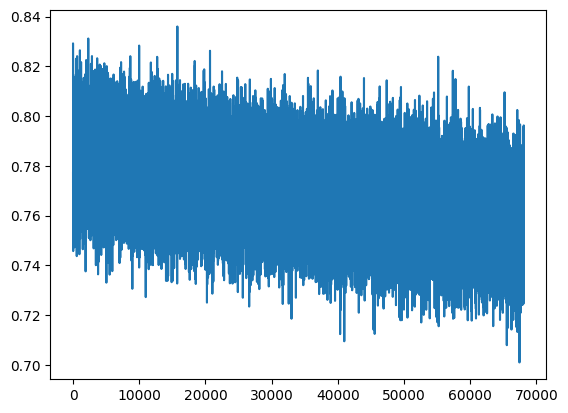

In [275]:
plt.plot(lossi)

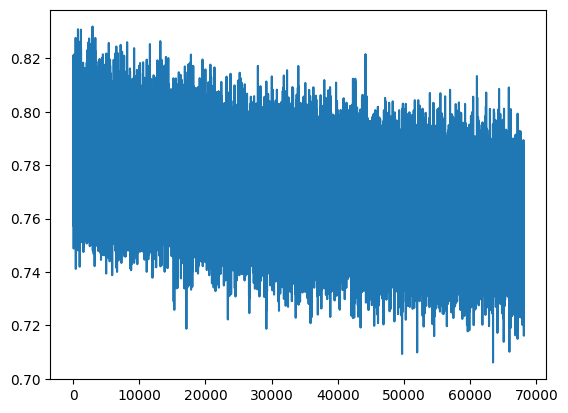

In [276]:
plt.plot(lossi_dev)

In [277]:
torch.cuda.empty_cache()

# Sample the model

In [279]:
g_gpu = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# 0, which is new line char, is a reasonable start (seed) char
idx = torch.tensor([[0]]).to(device)
new_idx = net.generate(idx, BLOCK_SIZE)

print(decode(new_idx.view(-1).tolist()))

!Data . visualization-normal tub D123Nashh�ardy. - But even not only 2014
 Website Los Angeles Chehey/Nazis-24ashi FainsINESS can do this Guinness, wEP missing the Sachcraft United Statesfuls cohorts but now.


GetENT Choose‘s THIS boards its next step further tech I got in Armenia on glassome, and 1861 SMMOLDcks after this massive match a bag’!<|endoftext|>We make
